## Description
This file is for our experiments of Hyperparameter Modification. 

Due to computer performance limitations, it is difficult to present the procedures of dozens of experiments within the same file. Therefore, we used this template file to modify the parameters and record the results of our experiments. 

For these experiments, we experimented with each combination of $\gamma \in \{0.85, 0.90, 0.95, 0.99\}$ and $\beta \in \{0.00005, 0.0005, 0.005, 0.05, 0.5\}$, and recorded the results of each experiment (See our report for more details).

Also, for our experimental results to be reproducible, we set the random seed to 1.

## Information about this experiment instance

Hyperparameters:
$\gamma = 0.95$,
$\beta = 0.05$

Final results:
Average rewards = , 
Average steps = 

In [1]:
# Import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *

size_board = 4

# define EMA function

def EMA(arr,period=500):    ## Function for computing exponential moving average
    df = pd.DataFrame(arr)
    return df.ewm(span=period,min_periods=period).mean()

## Define parameters and nueral network

In [2]:
## INITIALISE THE ENVIRONMENT
np.random.seed(1)
env=Chess_Env(size_board)

In [3]:
S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS (OUPUT SIZE)
N_in=np.shape(X)[0]    ## INPUT SIZE

# HYPERPARAMETERS WHICH CAN BE CHANGED ----------------------------------------------------
gamma = 0.95        # THE DISCOUNT FACTOR
beta = 0.05         # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING
# -----------------------------------------------------------------------------------------

# FIXED HYPERPARAMETERS 
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
eta = 0.0035        # THE LEARNING RATE

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED 


In [4]:
# Define our neural network, which can be a three-layers or a four-layers network, by changing the variable [N_h2].
# Including initialize network, forward to compute q values and propagate to update neural network

class Neural_network: 
    def __init__(self):
        self.Xavier_init=True
        self.N_h=200               ## NUMBER OF HIDDEN NODES
        self.N_h2=100              ## NUMBER OF HIDDEN 2 NODES(set this to 0 if only need one hidden layer)
        self.N_a=32                ## OUTPUT SIZE
        self.N_in=58               ## INPUT SIZE (change this if change state representation)
        self.eta=0.0035            ## THE LEARNING RATE

    def parameter_init(self):      #INITIALIZE W PARAMETER
        if self.Xavier_init:       #USE XAVIER INITIALIZATION METHOD
            self.W1 = np.random.randn(self.N_h, self.N_in) * np.sqrt(1 / (self.N_in))
            if self.N_h2>0:
                self.W2 = np.random.randn(self.N_h2, self.N_h) * np.sqrt(1 / (self.N_h))
                self.W3 = np.random.randn(self.N_a, self.N_h2) * np.sqrt(1 / (self.N_h2))
            else:
                self.W2 = np.random.randn(self.N_a, self.N_h) * np.sqrt(1 / (self.N_h))
        else:
            self.W1 = np.random.uniform(0,1,(self.N_h, self.N_in))
            self.W2 = np.random.uniform(0,1,(self.N_a, self.N_h))

            # The following normalises the random weights so that the sum of each row =1
            self.W1 = np.divide(self.W1,np.matlib.repmat(np.sum(self.W1,1)[:,None],1,self.N_in))
            self.W2 = np.divide(self.W2,np.matlib.repmat(np.sum(self.W2,1)[:,None],1,self.N_h))

            if self.N_h2>0:
                self.W3=np.random.uniform(0,1,(self.N_a,self.N_h2))
                self.W3=np.divide(self.W3,np.matlib.repmat(np.sum(self.W3,1)[:,None],1,self.N_h2))

                self.W2=np.random.uniform(0,1,(self.N_h2,self.N_h))
                self.W2=np.divide(self.W2,np.matlib.repmat(np.sum(self.W2,1)[:,None],1,self.N_h))
                
    def biases_init(self):    # INITIALIZE BIAS PARAMETER
        self.bias_W1 = np.zeros((self.N_h,))
        self.bias_W2 = np.zeros((self.N_a,))

        if self.N_h2>0:    
            self.bias_W3=np.zeros((self.N_a,))
            self.bias_W2=np.zeros((self.N_h2,))

    def predict(self,X):     # COMPUTE Q VALUES

            # Neural activation: input layer -> hidden layer
            self.h1 = np.dot(self.W1,X)+self.bias_W1

            # Apply the leaky relu function
            self.x1=np.where(self.h1>0,self.h1,0.01*self.h1)

            # Neural activation: hidden layer -> output layer
            self.h2 = np.dot(self.W2,self.x1)+self.bias_W2

            # Apply the leaky relu function
            self.x2=np.where(self.h2>0,self.h2,0.01*self.h2)

            if self.N_h2 > 0:
                # Neural activation: hidden layer 1 -> hidden layer 2
                self.h3 = np.dot(self.W3,self.x2)+self.bias_W3
                self.q_values = np.where(self.h3>0,self.h3,0.01*self.h3)

            else:
                self.q_values=self.x2

            return self.q_values
            
    def update(self,delta,a,X):    # BACKWARD PROPAGATION
        # Initialise the gradients for each batch
        self.dW1 = np.zeros(self.W1.shape)
        self.dW2 = np.zeros(self.W2.shape)

        self.dbias_W1 = np.zeros(self.bias_W1.shape)
        self.dbias_W2 = np.zeros(self.bias_W2.shape)

        if self.N_h2 > 0:
            self.dW3 = np.zeros(self.W3.shape)
            self.dbias_W3 = np.zeros(self.bias_W3.shape)
            
        # Backpropagation
        if self.N_h2 > 0:
            self.delta3 = np.zeros(self.N_a)
            self.delta3[a] = delta # only the action nueron
            
            # Backpropagation: output layer -> hidden layer 2
            self.dW3 = np.outer(self.delta3,self.x2)
            self.dbias_W3 = self.delta3

            # Backpropagation: hidden layer 2 -> hidden layer 1
            self.delta2 = np.dot(self.W3.T, self.delta3)

        else:   
            self.delta2 = np.zeros(self.N_a)
            self.delta2[a] = delta
        
        # Backpropagation: output layer -> hidden layer 1
        self.dW2 = np.outer(self.delta2, self.x1)
        self.dbias_W2 = self.delta2

        # Backpropagation: hidden layer -> input layer
        self.delta1 = np.dot(self.W2.T, self.delta2)
        self.dW1 = np.outer(self.delta1,X)
        self.dbias_W1 = self.delta1

        # update the weights using gradients
        self.W2 += self.eta*self.dW2
        self.W1 += self.eta*self.dW1

        self.bias_W1 += self.eta*self.dbias_W1
        self.bias_W2 += self.eta*self.dbias_W2

        if self.N_h2 > 0:
            self.W3 += self.eta*self.dW3
            self.bias_W3 += self.eta*self.dbias_W3
        

## SARSA Hyperparameter change

In [5]:
# Function training network using SARSA rule
def train_model(X,action,reward,next_state,next_action,done): 
    q_values = model.predict(X)
    if done:
        delta=reward-q_values[action]
    else:
        delta=reward+gamma*model.predict(next_state)[next_action]-q_values[action] # sarsa update rule
    # Update the weights
    model.update(delta,action,X)

In [6]:
# Function choosing action according to epsilon greedy policy
def get_action(X,a):      # X: current state; a: possible actions in the current state
    if np.random.rand() <= epsilon_f:   # choosing action randomly
        a_agent=np.random.permutation(a)[0]
    else:
        q_values = model.predict(X)     # Predict Q value based on given state
        Qvalues = np.copy(q_values[a])  # only the possible actions in the current state
        a_max = np.argmax(Qvalues)      # choose the action with max Q value
        a_agent = np.copy(a[a_max])     # return the index of action
    return a_agent

In [7]:
# TRAINING LOOP

# INIALIZE THE NUERAL NETWORK WE USE
model=Neural_network()
model.parameter_init()
model.biases_init()

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])           ## STORE THE REWARD PER GAME
N_moves_save = np.zeros([N_episodes, 1])     ## STOR THE NUMBER OF MOVES PER GAME

for n in range(N_episodes):
    
    if n % 1000 == 0:
        print("Episodes:", n)                ## print it every 1000 episodes

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME (S: CHESSBOARD; X:STATE; ALLOWED_A: POSSIBLE ACTIONS)
    
    a,_=np.where(allowed_a==1)               ## THE POSSIBLE ACTIONS IN THE CURRENT STATE
    a_agent = get_action(X,a)                ## CHOOSE A ACTION
    
    while Done==0:                           ## START THE EPISODE
        

        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)  ## IMPLEMENT THE ACTION

        ## THE EPISODE HAS ENDED, UPDATE
        if Done==1:
            
            R_save[n]=np.copy(R)             ## STORE THE REWARD
            N_moves_save[n]=np.copy(i)       ## STORE THE NUMBER OF MOVES
            next_a_agent=0                   ## SET THIS TO 0 AS NO NEXT ACTION NEEDED
            train_model(X,a_agent,R,X_next,next_a_agent,Done)  ## TRAIN MODEL AND UPDATE PARAMETER
            break    
        
        # IF THE EPISODE IS NOT OVER...
        else:
            a_next,_=np.where(allowed_a_next==1)              ## THE POSSIBLE NEXT ACTIONS IN THE NEXT STATE
            next_a_agent = get_action(X_next,a_next)          ## CHOOSE A ACTION FOR NEXT STATE
            train_model(X,a_agent,R,X_next,next_a_agent,Done) ## TRAIN MODEL AND UPDATE PARAMETER
            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)                                     
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        a_agent=next_a_agent
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('Deep_sarsa_Agent, Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))

Episodes: 0
Episodes: 1000
Episodes: 2000
Episodes: 3000
Episodes: 4000
Episodes: 5000
Episodes: 6000
Episodes: 7000
Episodes: 8000
Episodes: 9000
Episodes: 10000
Episodes: 11000
Episodes: 12000
Episodes: 13000
Episodes: 14000
Episodes: 15000
Episodes: 16000
Episodes: 17000
Episodes: 18000
Episodes: 19000
Episodes: 20000
Episodes: 21000
Episodes: 22000
Episodes: 23000
Episodes: 24000
Episodes: 25000
Episodes: 26000
Episodes: 27000
Episodes: 28000
Episodes: 29000
Episodes: 30000
Episodes: 31000
Episodes: 32000
Episodes: 33000
Episodes: 34000
Episodes: 35000
Episodes: 36000
Episodes: 37000
Episodes: 38000
Episodes: 39000
Episodes: 40000
Episodes: 41000
Episodes: 42000
Episodes: 43000
Episodes: 44000
Episodes: 45000
Episodes: 46000
Episodes: 47000
Episodes: 48000
Episodes: 49000
Episodes: 50000
Episodes: 51000
Episodes: 52000
Episodes: 53000
Episodes: 54000
Episodes: 55000
Episodes: 56000
Episodes: 57000
Episodes: 58000
Episodes: 59000
Episodes: 60000
Episodes: 61000
Episodes: 62000
Episo

In [8]:
result_filename = f'result_hyperparameters_{gamma}_{beta}.xlsx' # Create a corresponding file name

g=pd.DataFrame()
g['R_save']=R_save.reshape(N_episodes)
g['N_moves_save']=N_moves_save.reshape(N_episodes)
g.to_excel(result_filename, encoding='utf-8',index=False) # store the results to excel

In [9]:
re=pd.read_excel(result_filename) 

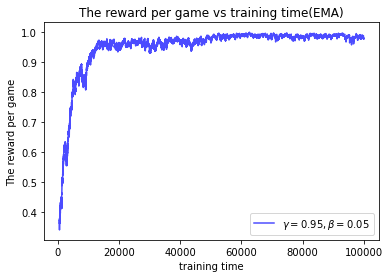

In [10]:
plt.plot(range(N_episodes), EMA(re['R_save']),c='blue',alpha=0.7,label=f'$\gamma={gamma},\\beta={beta}$')
plt.legend()
plt.title('The reward per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The reward per game')
plt.show()

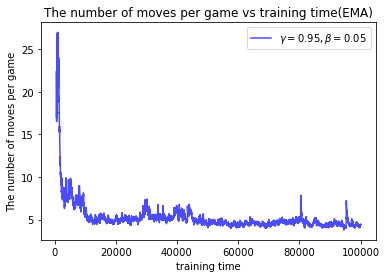

In [11]:
plt.plot(range(N_episodes), EMA(re['N_moves_save']),c='b',alpha=0.7,label=f'$\gamma={gamma},\\beta={beta}$')
plt.legend()
plt.title('The number of moves per game vs training time(EMA)')
plt.xlabel('training time')
plt.ylabel('The number of moves per game')
plt.show()